In [1]:
# 立体構造を保ったまま構造を綺麗にする
# combinestructureを使うと立体構造がkeepできないのでなるべく使わない様にする
# 例外処理はお絵描きで頑張る....

In [2]:
import os
from pathlib import Path

def is_kaggle_kernel():
    return os.path.exists('/kaggle/working')

if is_kaggle_kernel():

    BASE_DIR = Path("/kaggle")
    DATA_DIR = BASE_DIR / "input"
    OUTPUT_DIR = BASE_DIR / "working"
    print('on kaggle notebook')

else:
    BASE_DIR = Path(os.getcwd()) / './../'
    DATA_DIR = BASE_DIR / "data"
    OUTPUT_DIR = BASE_DIR / "output/eda"
    
class paths:    
    DATA_DIR = DATA_DIR
    
    # TEST_PATH = DATA_DIR / "test.parquet"
    OUTPUT_DIR = OUTPUT_DIR
    SHRUNKEN_DATA_DIR = DATA_DIR / "shrunken-data"
    
    TRAIN_PATH_ORIG = DATA_DIR / "shrunken-train-set/train.parquet"
    TEST_PATH_ORIG = DATA_DIR / "shrunken-train-set/test.parquet"
    
    TRAIN_PATH = SHRUNKEN_DATA_DIR / "train.parquet"
    TEST_PATH = SHRUNKEN_DATA_DIR / "test.parquet"
    SUB_PATH = SHRUNKEN_DATA_DIR / "sub.parquet"
    
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [3]:
import os
import gc
import math
import numpy as np
import pandas as pd
from glob import glob
import duckdb
import lightgbm as lgb

from rdkit import Chem
from rdkit.Chem import Draw

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import AllChem

import pickle
from funcs.chemical_func import combine_fragments

In [4]:
bb_cols = ['buildingblock1_smiles', 'buildingblock2_smiles','buildingblock3_smiles', 
           'buildingblock1_smiles_scaffold', "buildingblock2_smiles_scaffold", "buildingblock3_smiles_scaffold",
    ]

TARGETS = ['binds_BRD4', 'binds_HSA','binds_sEH']

df_train = pd.read_parquet(paths.TRAIN_PATH, columns=bb_cols + TARGETS)
df_test = pd.read_parquet(paths.TEST_PATH, columns=bb_cols)

df_train_orig = pd.read_parquet(paths.TRAIN_PATH_ORIG, columns=["molecule_smiles"])
df_test_orig = pd.read_parquet(paths.TEST_PATH_ORIG, columns=["molecule_smiles"])

with open(paths.SHRUNKEN_DATA_DIR / 'bb1_smiles2idx.pickle', 'rb') as file:
    bb1_smiles2idx = pickle.load(file)
with open(paths.SHRUNKEN_DATA_DIR / 'bb23_smiles2idx.pickle', 'rb') as file:
    bb23_smiles2idx = pickle.load(file)
    
bb1_idx2smiles = {val:key for key, val in bb1_smiles2idx.items()}
bb23_idx2smiles = {val:key for key, val in bb23_smiles2idx.items()}


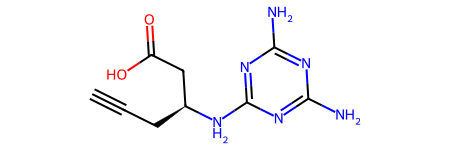

In [6]:
def replace_structure(main_mol, pattern_mol, replace_mol, idx=0):
    
    # patternにマッチする構造を削除して*に置き換える
    if main_mol.HasSubstructMatch(pattern_mol):
        main_mol = AllChem.ReplaceSubstructs(main_mol, pattern_mol, Chem.MolFromSmiles('*'))[idx]
        # *をreplace_molで置き換える
        main_mol = combine_fragments(main_mol, replace_mol)
    
    return main_mol

# テスト
bb1_smiles = "C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21"
pattern = "NC(=O)OCC1c2ccccc2-c2ccccc21"
bb1_replace = "Nc1nc(N)nc(N)n1"
bb1_mol = Chem.MolFromSmiles(bb1_smiles)
pattern_mol = Chem.MolFromSmiles(pattern)
bb1_replace_mol = Chem.MolFromSmiles(bb1_replace)

# replace_structure(bb1_mol, pattern_mol, bb1_replace_mol)
AllChem.ReplaceSubstructs(bb1_mol, pattern_mol, bb1_replace_mol)[0]

In [160]:
def clean_bb1_structure(main_smiles, del_t_butyl_halo_patterns=[], del_fluorene_halo_patterns=[], ex_dict={}):
    
    fluorene = Chem.MolFromSmiles("NC(=O)OCC1c2ccccc2-c2ccccc21")
    fluorene_without_n = Chem.MolFromSmiles("C(=O)OCC2c3ccccc3-c3ccccc32")
    triazine = Chem.MolFromSmiles("Nc1nc(N)nc(N)n1")
    t_butyl_O = Chem.MolFromSmiles("OC(C)(C)(C)")
    metyl = Chem.MolFromSmiles("C")
    br = Chem.MolFromSmiles("Br")
    I = Chem.MolFromSmiles("I")
    Cl = Chem.MolFromSmiles("Cl")
    
    # 例外処理
    if main_smiles in ex_dict.keys():
        return ex_dict[main_smiles]
    
    main_mol = Chem.MolFromSmiles(main_smiles)
    
    # fluoreneがなく、triazineにならないもの
    for pattern in del_t_butyl_halo_patterns:
        pattern_mol = Chem.MolFromSmiles(pattern)
        if main_mol.HasSubstructMatch(pattern_mol):
            main_mol = AllChem.ReplaceSubstructs(main_mol, t_butyl_O, metyl)[0]
            # main_mol = AllChem.DeleteSubstructs(main_mol, t_butyl_O)
            main_mol = AllChem.ReplaceSubstructs(main_mol, br, metyl)[0]
            main_mol = AllChem.ReplaceSubstructs(main_mol, I, metyl)[0]
            main_mol = AllChem.ReplaceSubstructs(main_mol, Cl, metyl)[0]
            
    for pattern in del_fluorene_halo_patterns:
        pattern_mol = Chem.MolFromSmiles(pattern)
        if main_mol.HasSubstructMatch(pattern_mol):
            main_mol = AllChem.ReplaceSubstructs(main_mol, fluorene_without_n, metyl)[0]
            main_mol = AllChem.ReplaceSubstructs(main_mol, br, metyl)[0]
            main_mol = AllChem.ReplaceSubstructs(main_mol, I, metyl)[0]
            main_mol = AllChem.ReplaceSubstructs(main_mol, Cl, metyl)[0]
    
    # fluorene→triazine
    main_mol = AllChem.ReplaceSubstructs(main_mol, fluorene, triazine)[0]
 
    main_smiles = Chem.MolToSmiles(main_mol)
            
    return main_smiles

# trainのbb1を一括で変換して確認

[N-]=[N+]=NCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O


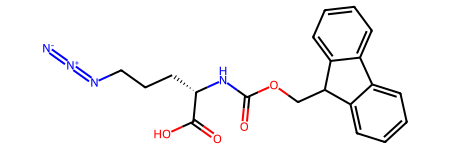

In [144]:
## trainのbb1を一括で見る
df = df_train.copy()
df = df.drop_duplicates(["buildingblock1_smiles"])
df['main'] = df_train_orig.iloc[df.index]["molecule_smiles"].values
df['buildingblock1_smiles'] = df['buildingblock1_smiles'].map(bb1_idx2smiles)
df['buildingblock2_smiles'] = df['buildingblock2_smiles'].map(bb23_idx2smiles)
df['buildingblock3_smiles'] = df['buildingblock3_smiles'].map(bb23_idx2smiles)
temp = df.iloc[270]

# 207, 209, 270
smiles = temp['buildingblock1_smiles']
print(smiles)
mol = Chem.MolFromSmiles(smiles)
mol

In [145]:
## trainのbb1を一括で見る
df = df_train.copy()
df = df.drop_duplicates(["buildingblock1_smiles"])
df['main'] = df_train_orig.iloc[df.index]["molecule_smiles"].values
df['buildingblock1_smiles'] = df['buildingblock1_smiles'].map(bb1_idx2smiles)
df['buildingblock2_smiles'] = df['buildingblock2_smiles'].map(bb23_idx2smiles)
df['buildingblock3_smiles'] = df['buildingblock3_smiles'].map(bb23_idx2smiles)

df['replaced'] = df['buildingblock1_smiles'].apply(lambda x: clean_bb1_structure(x))

col = ['buildingblock1_smiles',"replaced", 'main', 'buildingblock2_smiles','buildingblock3_smiles', ]
# col = ['buildingblock2_smiles','buildingblock3_smiles', 'main']
df[col] = df[col].applymap(lambda x: Chem.MolFromSmiles(x))

i = 2
chunk = 100
mols_list = df.iloc[i*chunk:i*chunk+chunk][col].values.flatten()
# mols_list = df[['buildingblock1_smiles','replaced', 'main', 'buildingblock2_smiles','buildingblock3_smiles']].values.flatten()
label_list  = [str(i) for i in range(i*100, i*100+100) for _ in range(5)]

img = Draw.MolsToGridImage(mols_list,
                        molsPerRow=5, #一列に配置する分子の数
                        subImgSize=(400,300),
                        maxMols =len(mols_list)*5,
                        legends=label_list
                            )
# img

/tmp/ipykernel_32156/1559621858.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[col] = df[col].applymap(lambda x: Chem.MolFromSmiles(x))


# TEST MOLECULE も

70
O=C(OCC1c2ccccc2-c2ccccc21)N1CCC(Cc2ccnc(Br)c2)(C(=O)O)CC1


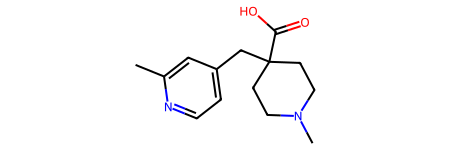

In [181]:
# デバッグ用
df = df_test.copy()
# trainに含まれるのは除く
train_bb1_idx = df_train['buildingblock1_smiles'].unique().tolist()
df = df.loc[~df_test['buildingblock1_smiles'].isin(train_bb1_idx)]
df = df.drop_duplicates(["buildingblock1_smiles"])
print(len(df))

df['main'] = df_test_orig.iloc[df.index]["molecule_smiles"].values
df['buildingblock1_smiles'] = df['buildingblock1_smiles'].map(bb1_idx2smiles)
df['buildingblock2_smiles'] = df['buildingblock2_smiles'].map(bb23_idx2smiles)
df['buildingblock3_smiles'] = df['buildingblock3_smiles'].map(bb23_idx2smiles)

i = 69
temp = df.iloc[i]
smiles = temp['buildingblock1_smiles']
print(smiles)
mol = Chem.MolFromSmiles(smiles)

# mol = AllChem.DeleteSubstructs(mol, Chem.MolFromSmiles("CC(C)(C)O"))
mol = AllChem.ReplaceSubstructs(mol, Chem.MolFromSmiles("Br"), Chem.MolFromSmiles("C"))[0]
mol = AllChem.ReplaceSubstructs(mol, Chem.MolFromSmiles("C(=O)OCC2c3ccccc3-c3ccccc32"), Chem.MolFromSmiles("C"))[0]
mol

In [183]:
df = df_test.copy()

# trainに含まれるのは除く
train_bb1_idx = df_train['buildingblock1_smiles'].unique().tolist()
df = df.loc[~df_test['buildingblock1_smiles'].isin(train_bb1_idx)]
df = df.drop_duplicates(["buildingblock1_smiles"])
print(len(df))

df['main'] = df_test_orig.iloc[df.index]["molecule_smiles"].values
df['buildingblock1_smiles'] = df['buildingblock1_smiles'].map(bb1_idx2smiles)
df['buildingblock2_smiles'] = df['buildingblock2_smiles'].map(bb23_idx2smiles)
df['buildingblock3_smiles'] = df['buildingblock3_smiles'].map(bb23_idx2smiles)

del_t_butyl_halo_patterns = [
    "CC(C)(C)OC(=O)N1CC(c2ccccc2)=C[C@H]1C(=O)O",
    "CC(C)(C)OC(=O)N1CCC(C(=O)O)(c2ccccc2)CC1",
    "CC(C)(C)OC(=O)N1CCC(COc2ccccc2C(=O)O)CC1",
    "CC(C)(C)OC(=O)N1CCC(COc2ccc(C(=O)O)cc2)CC1",
    "CC(C)(C)OC(=O)N1CCC(Oc2cc(C(=O)O)ccc2I)CC1",
    "CC(C)(C)OC(=O)N1CCC[C@@H](c2ccccc2)[C@@H]1C(=O)O",
    "CC(C)(C)OC(=O)N1CCC[C@@H](n2cccc2C(=O)O)C1",
    "CC(C)(C)OC(=O)N1CCC[C@H](n2cc(C(=O)O)c3ccccc32)C1",
    "CC(C)(C)OC(=O)N1CC[C@@](Cc2cccs2)(C(=O)O)C1",
    "CC(C)(C)OC(=O)N1CC[C@H](Oc2ccccc2C(=O)O)C1",
    "CC(C)(C)OC(=O)N1CC[C@](Cc2ccccc2)(C(=O)O)C1",
    "CC(C)(C)OC(=O)N1C[C@@H](C(=O)O)[C@H](c2ccccc2)C1",
    "CC(C)(C)OC(=O)N1C[C@@H](Oc2ccccn2)C[C@@H]1C(=O)O",
    "CC(C)(C)OC(=O)N1C[C@@H](n2cncc2)C[C@H]1C(=O)O",
    "CC(C)(C)OC(=O)N1C[C@H](Oc2ccccc2)C[C@@H]1C(=O)O",
    "CC(C)(C)OC(=O)N[C@@H]1CCCN(c2ncccc2C(=O)O)C1",
    "CN(c1cc(C(=O)O)ccn1)C1CCN(C(=O)OC(C)(C)C)C1",
    ]
del_fluorene_halo_patterns = [
    "CN(c1ncccc1C(=O)O)C1CCN(C(=O)OCC2c3ccccc3-c3ccccc32)C1",
    "O=C(NC1CN(c2cc(C(=O)O)ccn2)C1)OCC1c2ccccc2-c2ccccc21",
    "O=C(N[C@@H]1CCN(c2cc(C(=O)O)ccn2)C1)OCC1c2ccccc2-c2ccccc21",
    "O=C(N[C@@H]1CCN(c2ncccc2C(=O)O)C1)OCC1c2ccccc2-c2ccccc21",
    "O=C(O)[C@@H]1C=C(c2cccnc2)CN1C(=O)OCC1c2ccccc2-c2ccccc21",
    "O=C(O)[C@@H]1C=C(c2ccncc2)CN1C(=O)OCC1c2ccccc2-c2ccccc21",
    "O=C(O)[C@@H]1C=C(c2cncnc2)CN1C(=O)OCC1c2ccccc2-c2ccccc21",
    "O=C(O)[C@@H]1CN(C(=O)OCC2c3ccccc3-c3ccccc32)C[C@H]1c1cccnc1",
    "O=C(O)[C@@H]1CN(C(=O)OCC2c3ccccc3-c3ccccc32)C[C@H]1c1ccncc1",
    "O=C(O)c1cccnc1N1CCCN(C(=O)OCC2c3ccccc3-c3ccccc32)CC1",
    "O=C(O)c1cccnc1N1CCN(C(=O)OCC2c3ccccc3-c3ccccc32)CC1",
    "O=C(O)c1ccnc(N2CCCN(C(=O)OCC3c4ccccc4-c4ccccc43)CC2)c1",
    "O=C(O)c1ccnc(N2CCN(C(=O)OCC3c4ccccc4-c4ccccc43)CC2)c1",
    "O=C(OCC1c2ccccc2-c2ccccc21)N1CCC(Cc2ccncc2)(C(=O)O)C1",
    "O=C(OCC1c2ccccc2-c2ccccc21)N1CCC(Cc2ccncc2)(C(=O)O)CC1",
]
ex_dict = {}
df['replaced'] = df['buildingblock1_smiles'].apply(lambda x: clean_bb1_structure(x, 
                                                                                 del_t_butyl_halo_patterns=del_t_butyl_halo_patterns, 
                                                                                 del_fluorene_halo_patterns=del_fluorene_halo_patterns,
                                                                                 ex_dict=ex_dict))

col = ['buildingblock1_smiles',"replaced", 'main', 'buildingblock2_smiles','buildingblock3_smiles', ]
df[col] = df[col].applymap(lambda x: Chem.MolFromSmiles(x))

i = 0
chunk = 100
mols_list = df.iloc[i*chunk:i*chunk+chunk][col].values.flatten()
label_list  = [str(i) for i in range(i*100, i*100+100) for _ in range(5)]

img = Draw.MolsToGridImage(mols_list,
                        molsPerRow=5, #一列に配置する分子の数
                        subImgSize=(400,300),
                        maxMols = len(mols_list)*5,
                        legends = label_list,
                            )
# img


70


/tmp/ipykernel_32156/1639562063.py:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[col] = df[col].applymap(lambda x: Chem.MolFromSmiles(x))


# 一括チェック 

In [184]:
df = df_test.copy()
df = df.drop_duplicates(["buildingblock1_smiles"])
print(len(df))

df['main'] = df_test_orig.iloc[df.index]["molecule_smiles"].values
df['buildingblock1_smiles'] = df['buildingblock1_smiles'].map(bb1_idx2smiles)
df['buildingblock2_smiles'] = df['buildingblock2_smiles'].map(bb23_idx2smiles)
df['buildingblock3_smiles'] = df['buildingblock3_smiles'].map(bb23_idx2smiles)
df.iloc[145]['buildingblock1_smiles']

341


'O=C(N[C@H](Cc1c[nH]c2cc(Cl)ccc12)C(=O)O)OCC1c2ccccc2-c2ccccc21'

341


/tmp/ipykernel_32156/2458561150.py:56: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[col_mols] = df[col].applymap(lambda x: Chem.MolFromSmiles(x))


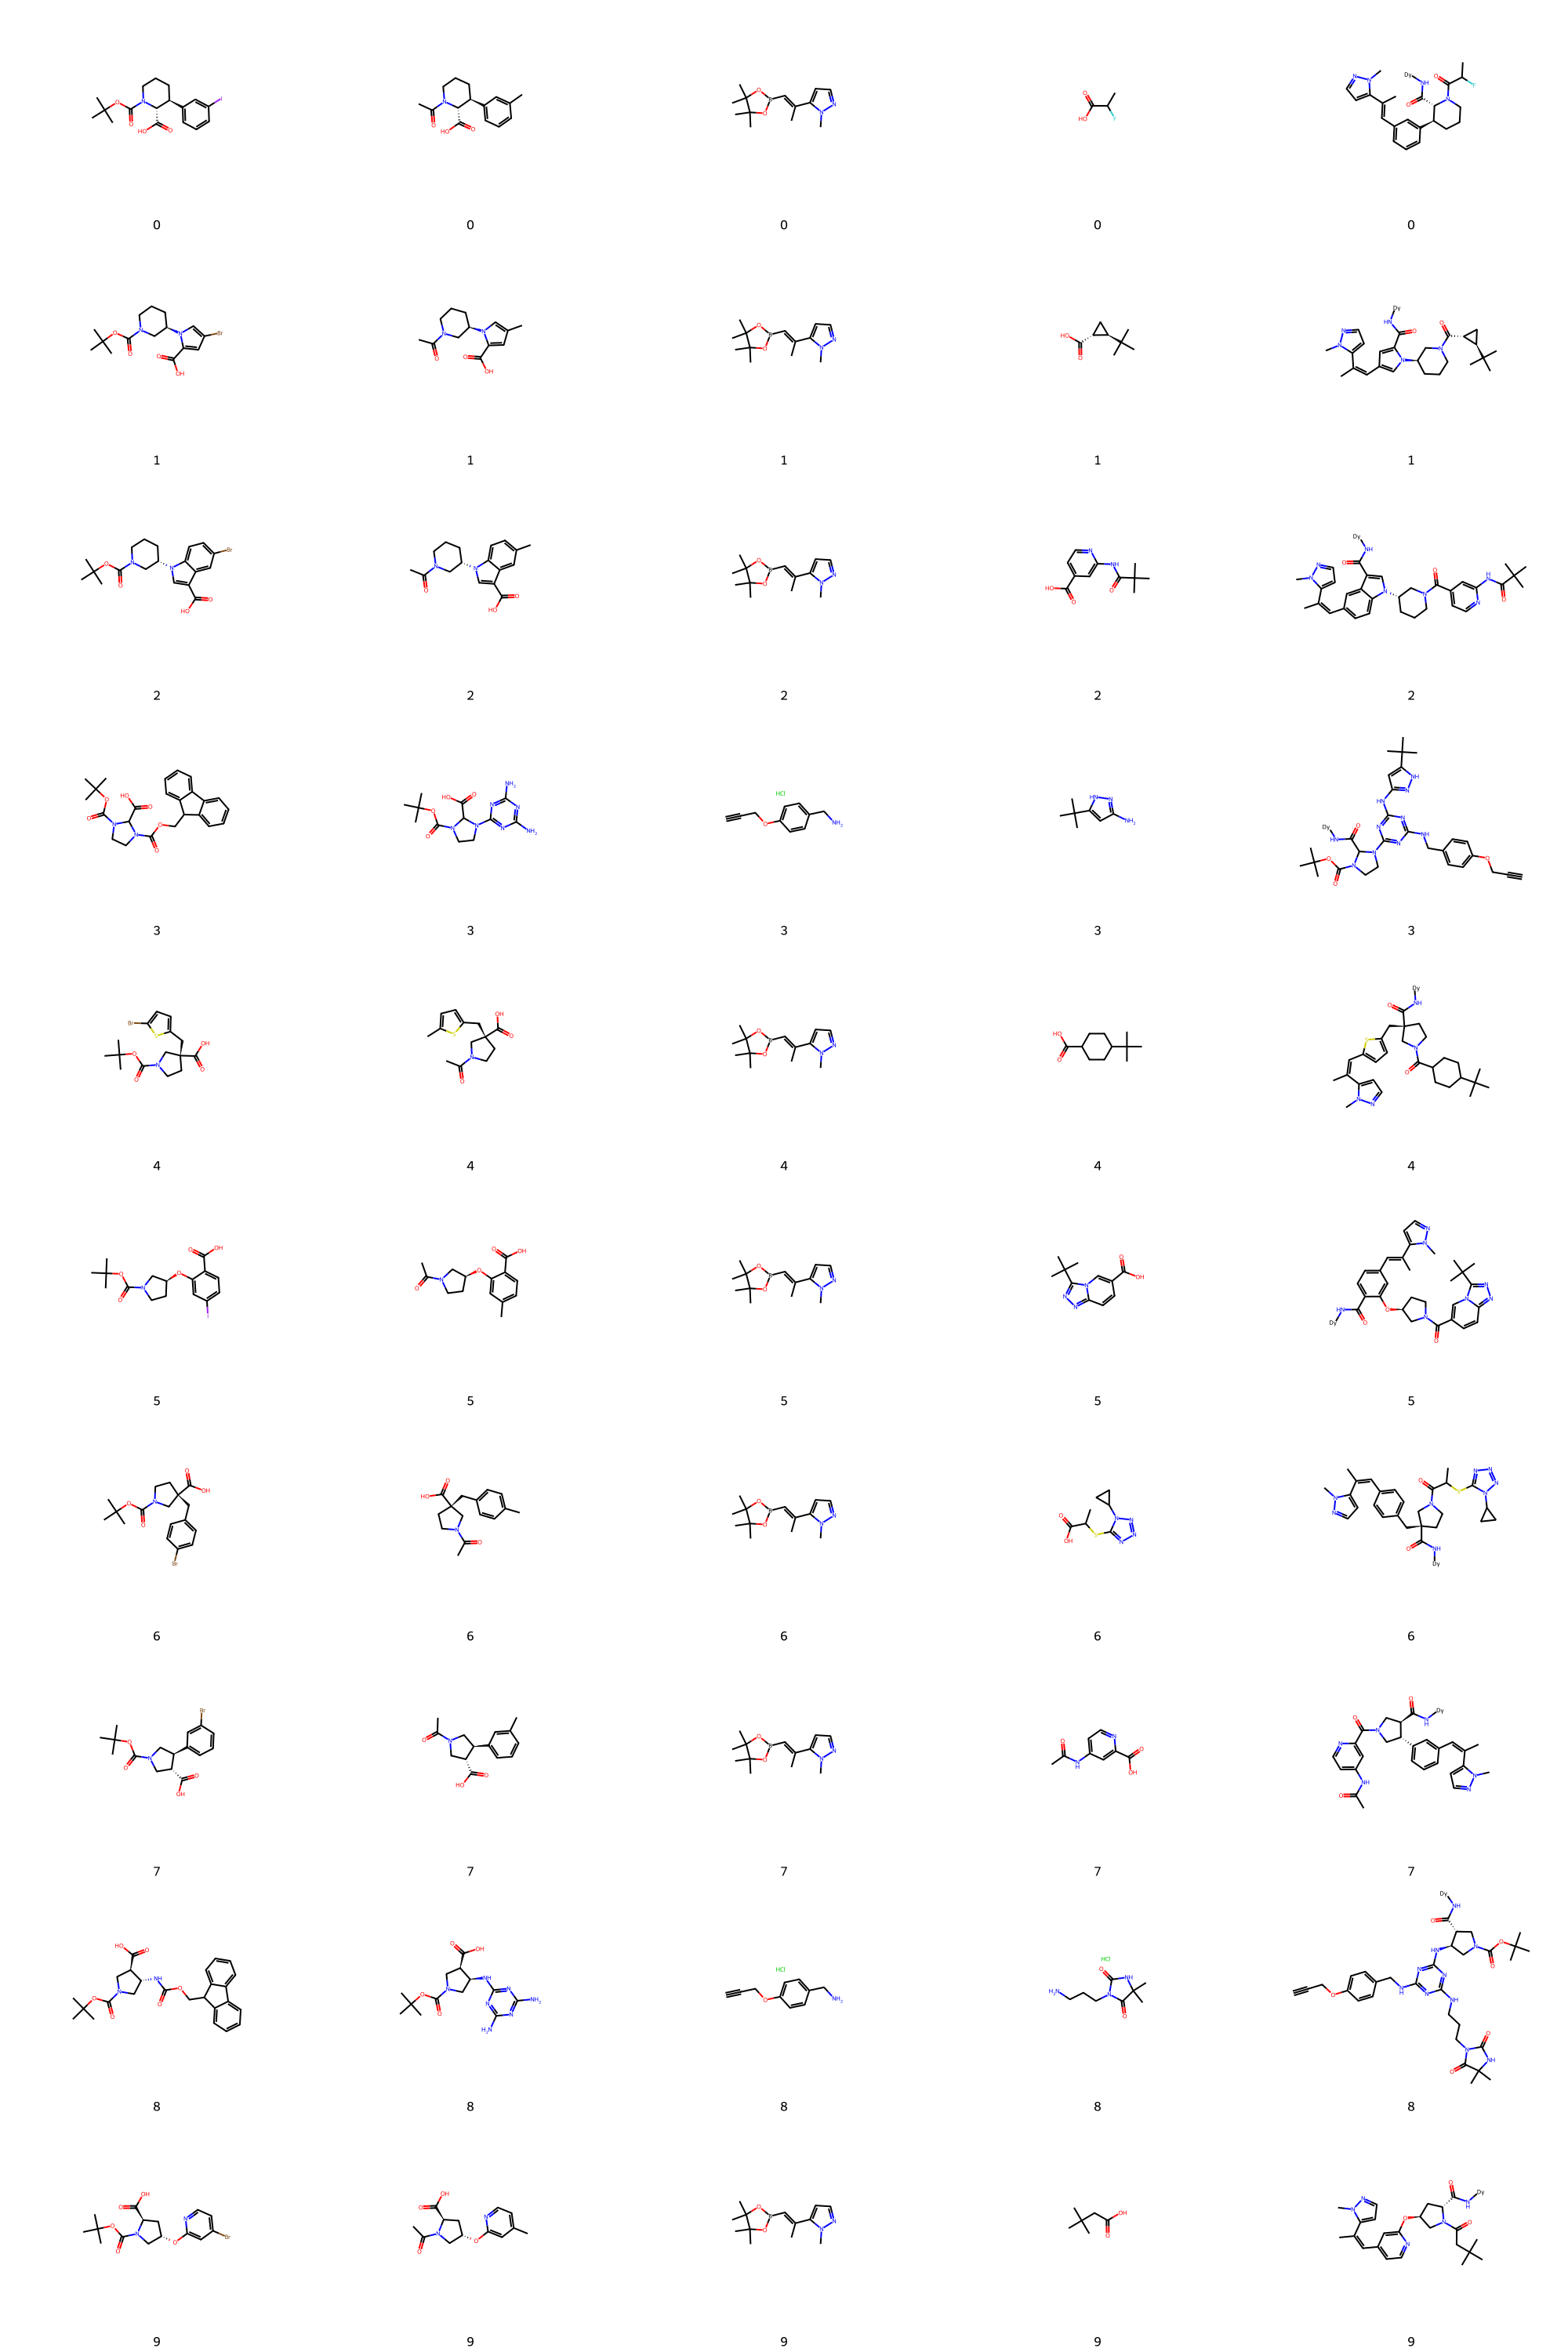

In [185]:
df = df_test.copy()
df = df.drop_duplicates(["buildingblock1_smiles"])
print(len(df))

df['main'] = df_test_orig.iloc[df.index]["molecule_smiles"].values
df['buildingblock1_smiles'] = df['buildingblock1_smiles'].map(bb1_idx2smiles)
df['buildingblock2_smiles'] = df['buildingblock2_smiles'].map(bb23_idx2smiles)
df['buildingblock3_smiles'] = df['buildingblock3_smiles'].map(bb23_idx2smiles)


del_t_butyl_halo_patterns = [
    "CC(C)(C)OC(=O)N1CC(c2ccccc2)=C[C@H]1C(=O)O",
    "CC(C)(C)OC(=O)N1CCC(C(=O)O)(c2ccccc2)CC1",
    "CC(C)(C)OC(=O)N1CCC(COc2ccccc2C(=O)O)CC1",
    "CC(C)(C)OC(=O)N1CCC(COc2ccc(C(=O)O)cc2)CC1",
    "CC(C)(C)OC(=O)N1CCC(Oc2cc(C(=O)O)ccc2I)CC1",
    "CC(C)(C)OC(=O)N1CCC[C@@H](c2ccccc2)[C@@H]1C(=O)O",
    "CC(C)(C)OC(=O)N1CCC[C@@H](n2cccc2C(=O)O)C1",
    "CC(C)(C)OC(=O)N1CCC[C@H](n2cc(C(=O)O)c3ccccc32)C1",
    "CC(C)(C)OC(=O)N1CC[C@@](Cc2cccs2)(C(=O)O)C1",
    "CC(C)(C)OC(=O)N1CC[C@H](Oc2ccccc2C(=O)O)C1",
    "CC(C)(C)OC(=O)N1CC[C@](Cc2ccccc2)(C(=O)O)C1",
    "CC(C)(C)OC(=O)N1C[C@@H](C(=O)O)[C@H](c2ccccc2)C1",
    "CC(C)(C)OC(=O)N1C[C@@H](Oc2ccccn2)C[C@@H]1C(=O)O",
    "CC(C)(C)OC(=O)N1C[C@@H](n2cncc2)C[C@H]1C(=O)O",
    "CC(C)(C)OC(=O)N1C[C@H](Oc2ccccc2)C[C@@H]1C(=O)O",
    "CC(C)(C)OC(=O)N[C@@H]1CCCN(c2ncccc2C(=O)O)C1",
    "CN(c1cc(C(=O)O)ccn1)C1CCN(C(=O)OC(C)(C)C)C1",
    ]
del_fluorene_halo_patterns = [
    "CN(c1ncccc1C(=O)O)C1CCN(C(=O)OCC2c3ccccc3-c3ccccc32)C1",
    "O=C(NC1CN(c2cc(C(=O)O)ccn2)C1)OCC1c2ccccc2-c2ccccc21",
    "O=C(N[C@@H]1CCN(c2cc(C(=O)O)ccn2)C1)OCC1c2ccccc2-c2ccccc21",
    "O=C(N[C@@H]1CCN(c2ncccc2C(=O)O)C1)OCC1c2ccccc2-c2ccccc21",
    "O=C(O)[C@@H]1C=C(c2cccnc2)CN1C(=O)OCC1c2ccccc2-c2ccccc21",
    "O=C(O)[C@@H]1C=C(c2ccncc2)CN1C(=O)OCC1c2ccccc2-c2ccccc21",
    "O=C(O)[C@@H]1C=C(c2cncnc2)CN1C(=O)OCC1c2ccccc2-c2ccccc21",
    "O=C(O)[C@@H]1CN(C(=O)OCC2c3ccccc3-c3ccccc32)C[C@H]1c1cccnc1",
    "O=C(O)[C@@H]1CN(C(=O)OCC2c3ccccc3-c3ccccc32)C[C@H]1c1ccncc1",
    "O=C(O)c1cccnc1N1CCCN(C(=O)OCC2c3ccccc3-c3ccccc32)CC1",
    "O=C(O)c1cccnc1N1CCN(C(=O)OCC2c3ccccc3-c3ccccc32)CC1",
    "O=C(O)c1ccnc(N2CCCN(C(=O)OCC3c4ccccc4-c4ccccc43)CC2)c1",
    "O=C(O)c1ccnc(N2CCN(C(=O)OCC3c4ccccc4-c4ccccc43)CC2)c1",
    "O=C(OCC1c2ccccc2-c2ccccc21)N1CCC(Cc2ccncc2)(C(=O)O)C1",
    "O=C(OCC1c2ccccc2-c2ccccc21)N1CCC(Cc2ccncc2)(C(=O)O)CC1",
]
ex_dict = {}
df['replaced'] = df['buildingblock1_smiles'].apply(lambda x: clean_bb1_structure(x, 
                                                                                 del_t_butyl_halo_patterns=del_t_butyl_halo_patterns, 
                                                                                 del_fluorene_halo_patterns=del_fluorene_halo_patterns,
                                                                                 ex_dict=ex_dict))

col = ['buildingblock1_smiles','replaced', 'buildingblock2_smiles','buildingblock3_smiles', 'main']
col_mols = [f'{c}_mol' for c in col]

df[col_mols] = df[col].applymap(lambda x: Chem.MolFromSmiles(x))

i = 2
chunk = 10
mols_list = df.iloc[i*chunk:i*chunk+chunk][col_mols].values.flatten()
label_list  = [str(i) for i in range(chunk) for _ in range(5)]

img = Draw.MolsToGridImage(mols_list,
                        molsPerRow=5, #一列に配置する分子の数
                        subImgSize=(400,300),
                        maxMols = len(mols_list)*5,
                        legends = label_list,
                            )
img

In [186]:
# 記述子計算
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from mordred import Calculator, descriptors 
from rdkit.Chem.Fingerprints import FingerprintMols

mols_list = df['replaced_mol'].values.tolist()
descriptor_names = [desc_name for desc_name, _ in Descriptors.descList]
descriptor_calculation = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
RDkit = [descriptor_calculation.CalcDescriptors(mol_temp) for mol_temp in mols_list]
df_RDkit = pd.DataFrame(RDkit, columns = descriptor_names)
df_RDkit

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.020056,-1.023540,11.020056,0.035285,0.398324,250.262,236.150,250.117824,96,0,...,0,0,0,1,0,0,0,0,1,0
1,10.597484,-0.978935,10.597484,0.046498,0.492453,236.235,224.139,236.102174,90,0,...,0,0,0,1,0,0,0,0,0,0
2,10.771900,-1.115273,10.771900,0.013070,0.471564,222.208,212.128,222.086524,84,0,...,0,0,0,1,0,0,0,0,0,0
3,11.093659,-1.393866,11.093659,0.032269,0.503568,236.235,224.139,236.102174,90,0,...,0,0,0,1,0,0,0,0,0,0
4,10.597484,-0.978935,10.597484,0.046498,0.492453,236.235,224.139,236.102174,90,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,11.053587,-0.894731,11.053587,0.314909,0.854025,249.314,230.162,249.147727,98,0,...,0,0,0,0,0,0,0,0,0,0
337,10.985686,-0.897336,10.985686,0.311507,0.822876,235.287,218.151,235.132077,92,0,...,0,0,0,0,0,0,0,0,0,0
338,11.516093,-0.683967,11.516093,0.593287,0.857141,234.299,216.155,234.136828,92,0,...,0,0,0,0,0,0,0,0,0,0
339,11.638134,-0.661977,11.638134,0.596921,0.884766,248.326,228.166,248.152478,98,0,...,0,0,0,0,0,0,0,0,0,0
